In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import torch
import glob
from graph_functions import image_to_graph, unflatten, flatten
from utils import add_positional_encoding

import warnings
warnings.filterwarnings("ignore")

In [61]:
mask = np.isnan(xr.open_zarr('data/era5_hb_daily.zarr').siconc.isel(time=0)).values
ds = xr.open_zarr('data/era5_hb_daily.zarr')
# ds = xr.open_mfdataset(glob.glob('data/hb_era5_glorys_nc/hb_era5_glorys_*.nc'))

mask = np.isnan(ds.isel(time=0).siconc).values

ds = ds[['siconc', 't2m']]

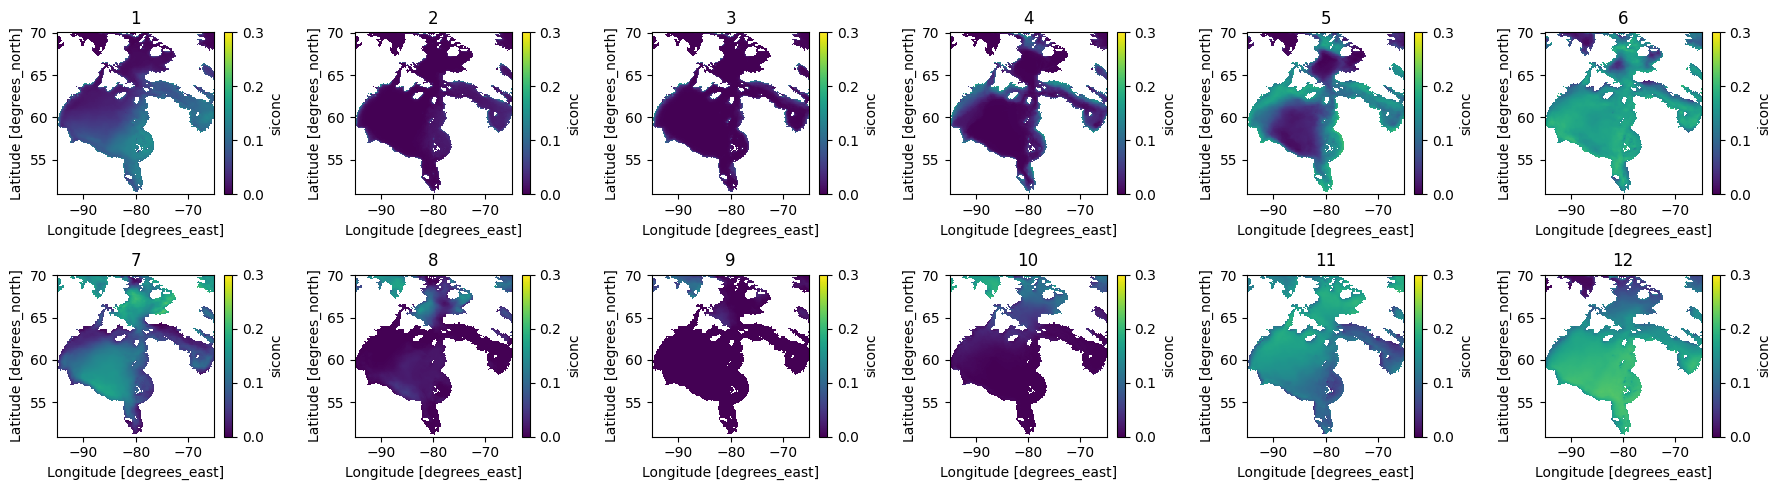

In [204]:
fig, axs = plt.subplots(2, 6, figsize=(18, 5))
for i, month in enumerate(range(1, 13)):
    months = ((month - 2) % 12 + 1, month, month % 12 + 1)
    ds.sel(time=ds.time.dt.month.isin(months)).siconc.fillna(0).var('time').where(~mask).plot(ax=axs.flatten()[i], vmin=0, vmax=0.3)
    axs.flatten()[i].set_title(month)

plt.tight_layout()
plt.show()

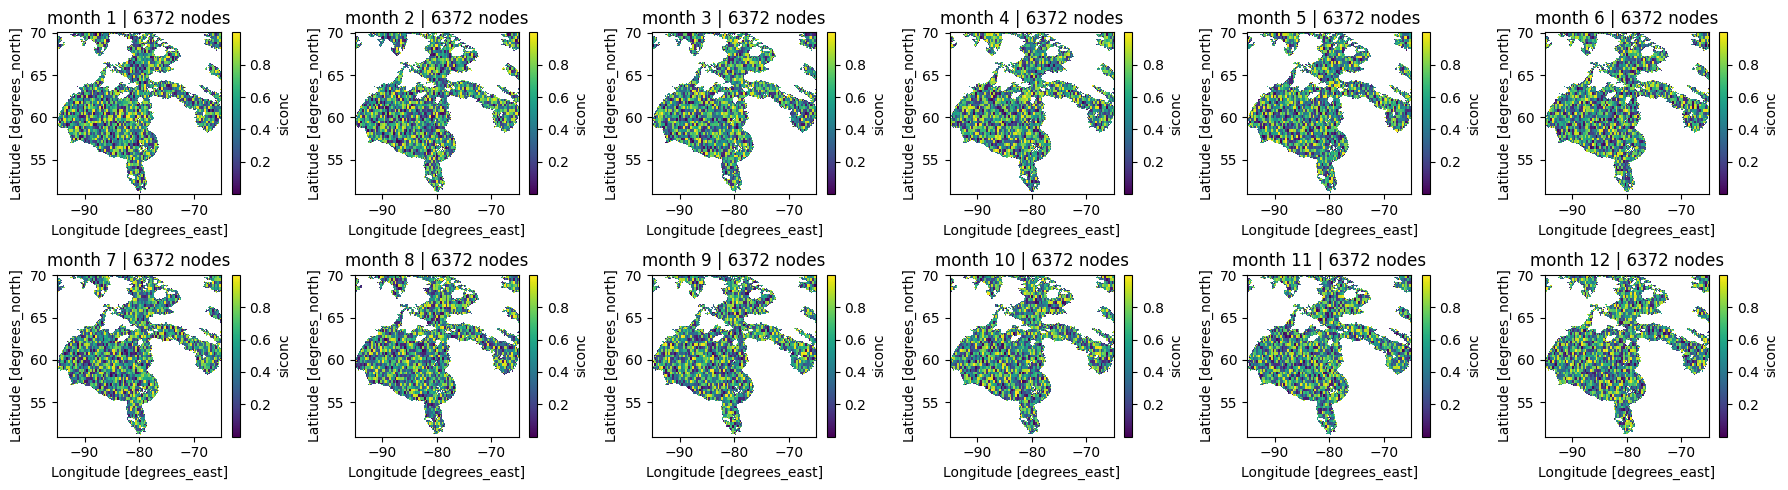

In [205]:
fig, axs = plt.subplots(2, 6, figsize=(18, 5))
for i, month in enumerate(range(1, 13)):
    months = ((month - 2) % 12 + 1, month, month % 12 + 1, month % 12 + 2)
    arr_xr = ds.sel(time=ds.time.dt.month.isin(months)).siconc.var('time')
    arr = arr_xr.values
    arr = torch.Tensor(np.expand_dims(np.nan_to_num(arr), (0, -1)))
    arr = add_positional_encoding(arr)

    image_shape = mask.shape#(77, 121)

    data = image_to_graph(arr, thresh=1, max_grid_size=4, mask=mask, use_edge_attrs=True, resolution=0.25)
    
    data['data'][0] = torch.Tensor(np.random.random(data['data'][0].shape))

    arr = unflatten(data['data'], data['mapping'], image_shape, mask=~mask)

    arr_xr.values = arr[0, :, :, 0]
    arr_xr.where(~mask).plot(ax=axs.flatten()[i])
    axs.flatten()[i].set_title(f'month {month} | {len(data["graph_nodes"])} nodes')

plt.tight_layout()
plt.show()

In [15]:
arr_xr

<xarray.DataArray 'siconc' (latitude: 77, longitude: 121)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0780411 , 0.07844596, 0.08020625, ..., 0.13094227, 0.13094227,
        0.13340642],
       [0.        , 0.        , 0.        , ..., 0.13094227, 0.13094227,
        0.13340642],
       [0.        , 0.        , 0.        , ..., 0.14374958, 0.14374958,
        0.14467056]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 51.0 51.25 51.5 51.75 ... 69.5 69.75 70.0
  * longitude  (longitude) float32 -95.0 -94.75 -94.5 ... -65.5 -65.25 -65.0

Text(0.5, 1.0, 'month 6 | 1732 nodes')

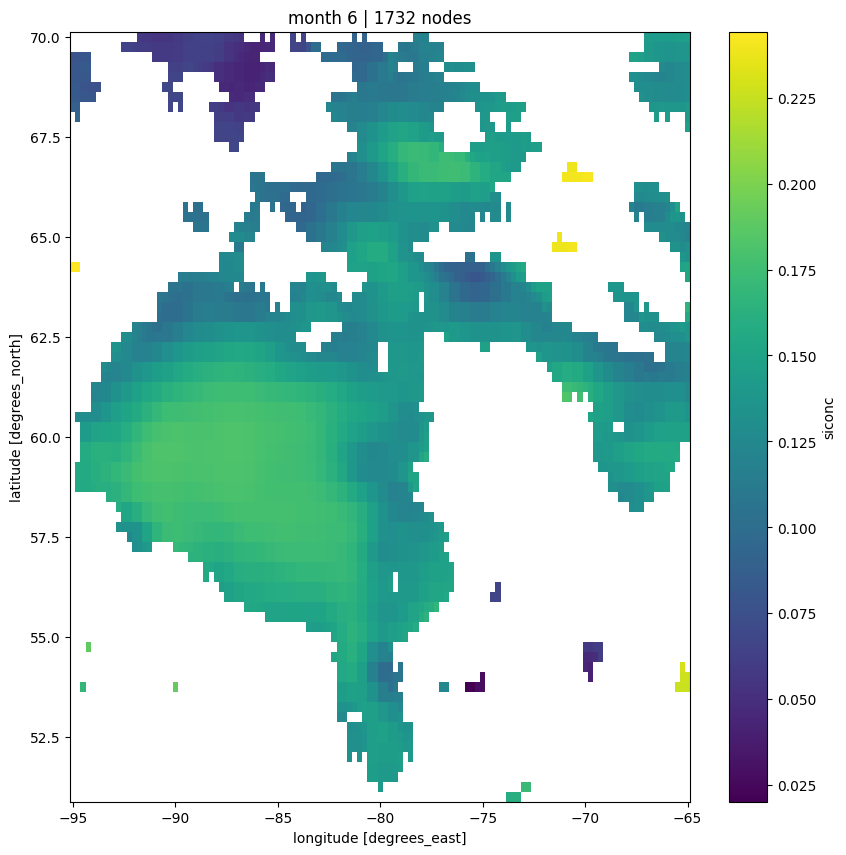

In [62]:
fig = plt.figure(figsize=(10, 10))
month = 6
months = ((month - 2) % 12 + 1, month, month % 12 + 1, month % 12 + 2)
arr_xr = ds.sel(time=ds.time.dt.month.isin(months)).siconc.var('time')
arr = arr_xr.values
arr = torch.Tensor(np.expand_dims(np.nan_to_num(arr), (0, -1)))
arr = add_positional_encoding(arr)

image_shape = mask.shape#(77, 121)

data = image_to_graph(arr, thresh=10, max_grid_size=2, mask=mask, use_edge_attrs=True, resolution=0.25)

# data['data'][0] = torch.Tensor(np.random.random(data['data'][0].shape))

arr = unflatten(data['data'], data['mapping'], image_shape, mask=~mask)

arr_xr.values = arr[0, :, :, 0]
arr_xr.where(~mask).plot()
plt.title(f'month {month} | {len(data["graph_nodes"])} nodes')

In [265]:
years = range(2010, 2018)
for year in years:
    arr = ds.sel(time=ds.time.dt.year == year).to_array().values  # (n_samples, w, h, c)
    arr = np.nan_to_num(np.moveaxis(arr, 0, -1))
    arr = torch.Tensor(arr)
    arr = add_positional_encoding(arr)
    

    arr = flatten(arr, data['mapping'], data['n_pixels_per_node'], mask=~mask)
    
    with open(f'data/hb_era5_glorys_np/hb_era5_glorys_{year}.npy', 'wb') as f:
        np.save(f, arr)

In [275]:
import pickle
with open(f'data/hb_era5_glorys_np/mapping.npy', 'wb') as handle:
    pickle.dump(data['mapping'], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [276]:
with open(f'data/hb_era5_glorys_np/mapping.npy', 'rb') as handle:
    b = pickle.load(handle)

In [ ]:
ds

In [281]:
import pickle
del data['data']
with open(f'data/hb_era5_glorys_np/graph_data', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [273]:
with open(f'data/hb_era5_glorys_np/mapping.npy', 'wb') as f:
    np.save(f, data['mapping'].to_dense().numpy().astype(bool))
    
with open(f'data/hb_era5_glorys_np/mapping.npy', 'wb') as f:
    np.save(f, data['mapping'].to_dense().numpy().astype(bool))



In [32]:
ds.data_vars

Data variables:
    d2m      (time, latitude, longitude) float32 dask.array<chunksize=(239, 39, 61), meta=np.ndarray>
    e        (time, latitude, longitude) float32 dask.array<chunksize=(239, 39, 61), meta=np.ndarray>
    fg10     (time, latitude, longitude) float32 dask.array<chunksize=(239, 39, 61), meta=np.ndarray>
    msl      (time, latitude, longitude) float32 dask.array<chunksize=(239, 39, 61), meta=np.ndarray>
    mwd      (time, latitude, longitude) float32 dask.array<chunksize=(239, 39, 61), meta=np.ndarray>
    mwp      (time, latitude, longitude) float32 dask.array<chunksize=(239, 39, 61), meta=np.ndarray>
    sf       (time, latitude, longitude) float32 dask.array<chunksize=(239, 39, 61), meta=np.ndarray>
    siconc   (time, latitude, longitude) float32 dask.array<chunksize=(239, 39, 61), meta=np.ndarray>
    slhf     (time, latitude, longitude) float32 dask.array<chunksize=(239, 39, 61), meta=np.ndarray>
    smlt     (time, latitude, longitude) float32 dask.array<chunks

In [51]:
ds.

<xarray.Dataset>
Dimensions:    (time: 2930, latitude: 229, longitude: 361)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2018-01-01
  * longitude  (longitude) float32 -95.0 -94.92 -94.83 ... -65.17 -65.08 -65.0
    area       (latitude, longitude) float32 dask.array<chunksize=(229, 361), meta=np.ndarray>
    distx      (latitude, longitude) float32 dask.array<chunksize=(229, 361), meta=np.ndarray>
    disty      (latitude, longitude) float32 dask.array<chunksize=(229, 361), meta=np.ndarray>
  * latitude   (latitude) float32 51.0 51.08 51.17 51.25 ... 69.83 69.92 70.0
    depth      float32 0.494
Data variables:
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(366, 229, 361), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(366, 229, 361), meta=np.ndarray>
Attributes: (12/24)
    Conventions:        CF-1.4
    bulletin_date:      2020-06-03 00:00:00
    bulletin_type:      operational
    comment:            CMEMS product
    domain_name:        GL12
    easting:            longitude
    ...                 ...
    northing:           latitude
    references:         http://www.mercator-ocean.fr
    source:             MERCATOR GLORYS12V1
    title:              daily mean fields from Global Ocean Physics Analysis ...
    z_max:              5727.917
    z_min:              0.494025

Text(0.5, 1.0, '2017-06-19 | 1732 nodes')

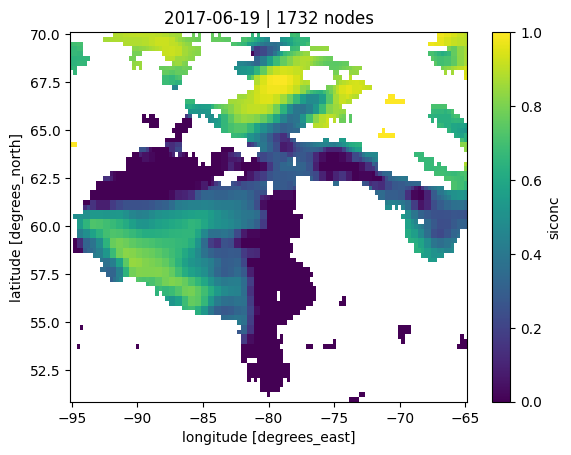

In [65]:
year = 2017
arr = ds.sel(time=ds.time.dt.year == year).to_array()  # (n_samples, w, h, c)
dt = arr.isel(time=169).time.values
arr = np.nan_to_num(np.moveaxis(arr.values, 0, -1))
arr = torch.Tensor(arr)
arr = add_positional_encoding(arr)


arr = flatten(arr, data['mapping'], data['n_pixels_per_node'], mask=~mask)

arr = unflatten(arr, data['mapping'], image_shape, mask=~mask)

arr_xr.values = arr[169, :, :, 0]
arr_xr.where(~mask).plot()
plt.title(f'{str(dt)[:10]} | {len(data["graph_nodes"])} nodes')

Text(0.5, 1.0, '2017-06-19 | Full res')

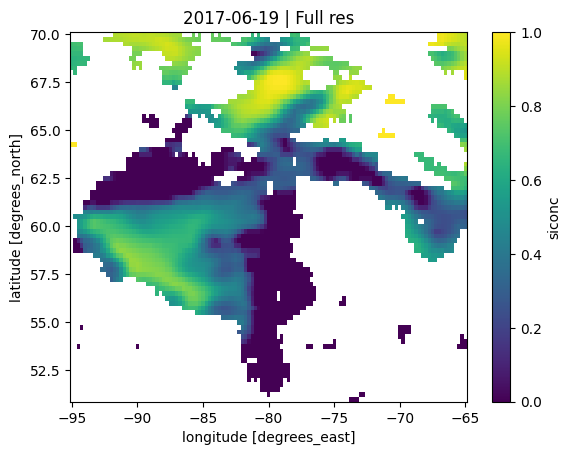

In [67]:
ds.sel(time=ds.time.dt.year == year).fillna(0).where(~mask).siconc.isel(time=169).plot()
plt.title(f'{str(dt)[:10]} | Full res')

Text(0.5, 1.0, 'month 6 | 1354 nodes')

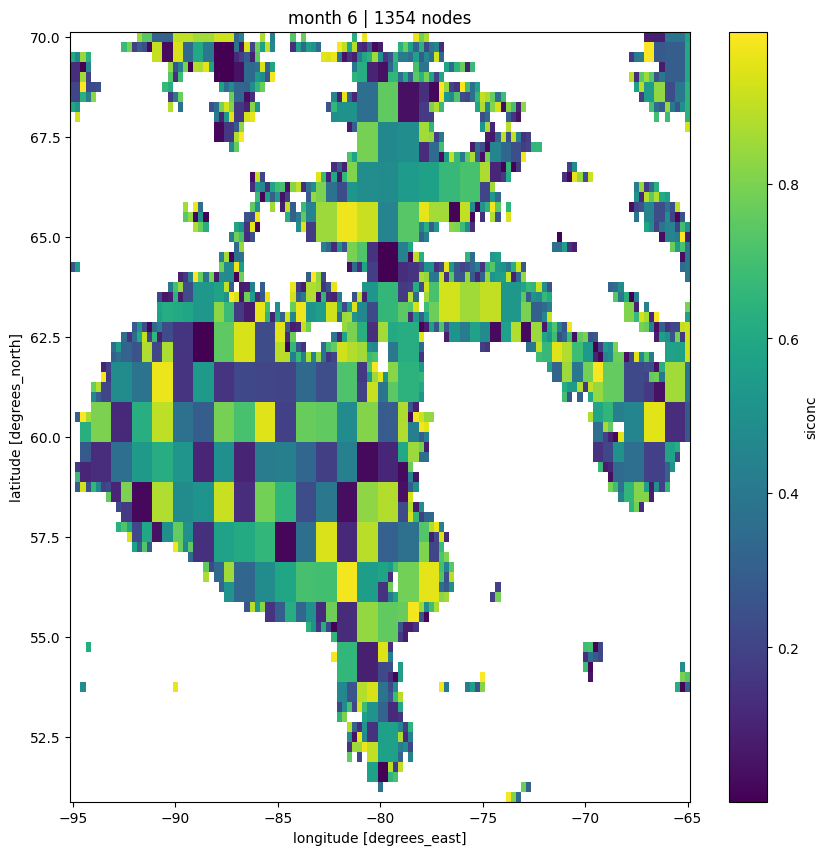

In [189]:
fig = plt.figure(figsize=(10, 10))
month = 6
months = ((month - 2) % 12 + 1, month, month % 12 + 1, month % 12 + 2)
arr_xr = ds.sel(time=ds.time.dt.month.isin(months)).siconc.var('time')
arr = arr_xr.values
arr = torch.Tensor(np.expand_dims(np.nan_to_num(arr), (0, -1)))
arr = add_positional_encoding(arr)

image_shape = mask.shape#(77, 121)

data = image_to_graph(arr, thresh=1, max_grid_size=4, mask=mask, use_edge_attrs=True, resolution=0.25)

data['data'][0] = torch.Tensor(np.random.random(data['data'][0].shape))

arr = unflatten(data['data'], data['mapping'], image_shape, mask=~mask)

arr_xr.values = arr[0, :, :, 0]
arr_xr.where(~mask).plot()
plt.title(f'month {month} | {len(data["graph_nodes"])} nodes')

In [129]:
fig, axs = plt.subplots(2, 6, figsize=(18, 5))
for i, month in enumerate(range(1, 13)):
    months = ((month - 2) % 12 + 1, month, month % 12 + 1)
    arr_xr = ds.sel(time=ds.time.dt.month.isin(months)).siconc.var('time')
    arr = arr_xr.values
    arr = torch.Tensor(np.expand_dims(np.nan_to_num(arr), (0, -1)))
    arr = add_positional_encoding(arr)

    image_shape = (77, 121)

    data = image_to_graph(arr, thresh=0.05, max_grid_size=64, mask=mask, use_edge_attrs=True, resolution=0.25)

    arr = unflatten(data['data'], data['mapping'], image_shape, mask=~mask)

    arr_xr.values = arr[0, :, :, 0]
    arr_xr.where(~mask).plot(ax=axs.flatten()[i])
    axs.flatten()[i].set_title(f'month | {len(data["graph_nodes"])} nodes')

plt.tight_layout()
plt.show()

<xarray.DataArray 'siconc' (latitude: 77, longitude: 121)>
dask.array<moment_agg-aggregate, shape=(77, 121), dtype=float32, chunksize=(39, 61), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 51.0 51.25 51.5 51.75 ... 69.5 69.75 70.0
  * longitude  (longitude) float32 -95.0 -94.75 -94.5 ... -65.5 -65.25 -65.0

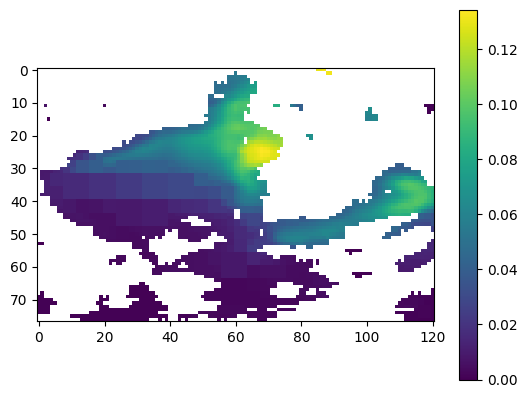